#  <font color='blue'> House Prices : Data cleaning, visualization and modeling  </font>

In [1]:
# Import packages
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import sklearn.metrics as metrics
import math

<font color='gris'>  Importing **train** and **test** datasets </font>

In [2]:
sample_submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
#Creating a copy of the train and test datasets
c_test  = test.copy()
c_train  = train.copy()


* <font color='gris'>  Getting information about train dataset </font>

In [3]:
c_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000



* <font color='gris'>  Getting information about test dataset </font>


In [4]:
c_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


 <font color='gris'> 1. We have 81 columns.
2. Our target variable is SalePrice.
3. Id is just an index that we can drop but we will need it in the final submission.
1. We have many missing values </font>


 <font color='red'>   * * * * we have 79 features in our dataset. </font>




* <font color='gris'>  Concat Train and Test datasets </font>


In [5]:
c_train['train']  = 1
c_test['train']  = 0
df = pd.concat([c_train, c_test], axis=0,sort=False)


#  <font color='blue'> Data preprocessing </font>


* <font color='gris'>  Calculating the percentage of missing values of each feature </font>


In [6]:
#Percentage of NAN Values 
NAN = [(c, df[c].isna().mean()*100) for c in df]
NAN = pd.DataFrame(NAN, columns=["column_name", "percentage"])

* <font color='gris'>  Features with more than 50% of missing values. </font>

In [7]:
NAN = NAN[NAN.percentage > 50]
NAN.sort_values("percentage", ascending=False)

,column_name,percentage
72,PoolQC,99.657417
74,MiscFeature,96.402878
6,Alley,93.216855
73,Fence,80.438506


* <font color='gris'>  We can drop PoolQC, MiscFeature, Alley and Fence features because they have more than 80% of missing values. <font>

In [8]:
#Drop PoolQC, MiscFeature, Alley and Fence features
df = df.drop(['Alley','PoolQC','Fence','MiscFeature'],axis=1)


* <font color='gris'>  Now we will select numerical and categorical features  <font>

In [9]:
object_columns_df = df.select_dtypes(include=['object'])
numerical_columns_df =df.select_dtypes(exclude=['object'])


* <font color='gris'>  **Categorical Features** :  <font>

In [10]:
object_columns_df.dtypes

MSZoning         object
Street           object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinType2     object
Heating          object
HeatingQC        object
CentralAir       object
Electrical       object
KitchenQual      object
Functional       object
FireplaceQu      object
GarageType       object
GarageFinish     object
GarageQual       object
GarageCond       object
PavedDrive       object
SaleType         object
SaleCondition    object
dtype: object

* <font color='gris'>  **Numerical Features** :  <font>

In [11]:
numerical_columns_df.dtypes

Id                 int64
MSSubClass         int64
LotFrontage      float64
LotArea            int64
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
MasVnrArea       float64
BsmtFinSF1       float64
BsmtFinSF2       float64
BsmtUnfSF        float64
TotalBsmtSF      float64
1stFlrSF           int64
2ndFlrSF           int64
LowQualFinSF       int64
GrLivArea          int64
BsmtFullBath     float64
BsmtHalfBath     float64
FullBath           int64
HalfBath           int64
BedroomAbvGr       int64
KitchenAbvGr       int64
TotRmsAbvGrd       int64
Fireplaces         int64
GarageYrBlt      float64
GarageCars       float64
GarageArea       float64
WoodDeckSF         int64
OpenPorchSF        int64
EnclosedPorch      int64
3SsnPorch          int64
ScreenPorch        int64
PoolArea           int64
MiscVal            int64
MoSold             int64
YrSold             int64
SalePrice        float64
train              int64
dtype: object


* <font color='gris'>  Deeling with **categorical** feature  <font>

In [12]:
#Number of null values in each feature
null_counts = object_columns_df.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))


Number of null values in each column:
MSZoning            4
Street              0
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         24
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           81
BsmtCond           82
BsmtExposure       82
BsmtFinType1       79
BsmtFinType2       80
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
KitchenQual         1
Functional          2
FireplaceQu      1420
GarageType        157
GarageFinish      159
GarageQual        159
GarageCond        159
PavedDrive          0
SaleType            1
SaleCondition       0
dtype: int64



* <font color='gris'>   We will fill -- **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, GarageType, GarageFinish, GarageQual, FireplaceQu, GarageCond** -- with "None" (Take a look in the data description). </font>
* <font color='gris'>    We will fill the rest of features with th most frequent value (using its own most frequent value). </font>

In [13]:
columns_None = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','GarageType','GarageFinish','GarageQual','FireplaceQu','GarageCond']
object_columns_df[columns_None]= object_columns_df[columns_None].fillna('None')

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [14]:
columns_with_lowNA = ['MSZoning','Utilities','Exterior1st','Exterior2nd','MasVnrType','Electrical','KitchenQual','Functional','SaleType']
#fill missing values for each column (using its own most frequent value)
object_columns_df[columns_with_lowNA] = object_columns_df[columns_with_lowNA].fillna(object_columns_df.mode().iloc[0])


* <font color='gris'>   Now we have a clean categorical features </font>
* <font color='gris'>   In the next step we will deal with the **numerical** features </font>black

In [15]:
#Number of null values in each feature
null_counts = numerical_columns_df.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))


Number of null values in each column:
Id                  0
MSSubClass          0
LotFrontage       486
LotArea             0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
MasVnrArea         23
BsmtFinSF1          1
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
1stFlrSF            0
2ndFlrSF            0
LowQualFinSF        0
GrLivArea           0
BsmtFullBath        2
BsmtHalfBath        2
FullBath            0
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
TotRmsAbvGrd        0
Fireplaces          0
GarageYrBlt       159
GarageCars          1
GarageArea          1
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SalePrice        1459
train               0
dtype: int64


1. <font color='gris'>  Fill GarageYrBlt and LotFrontage </font>
1. <font color='gris'>  Fill the rest of columns with 0 </font>

In [16]:
print((numerical_columns_df['YrSold']-numerical_columns_df['YearBuilt']).median())
print(numerical_columns_df["LotFrontage"].median())


35.0
68.0


 <font color='gris'>  So we will fill the year with 1979 and the Lot frontage with 68 </font>


In [17]:
numerical_columns_df['GarageYrBlt'] = numerical_columns_df['GarageYrBlt'].fillna(numerical_columns_df['YrSold']-35)
numerical_columns_df['LotFrontage'] = numerical_columns_df['LotFrontage'].fillna(68)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


 <font color='gris'> Fill the rest of columns with 0  <font>


In [18]:
numerical_columns_df= numerical_columns_df.fillna(0)

* <font color='gris'>  We finally end up with a clean dataset  <font>


* <font color='gris'> After making some plots we found that we have some colums with low variance so we decide to delete them  <font>


AllPub    2918
NoSeWa       1
Name: Utilities, dtype: int64

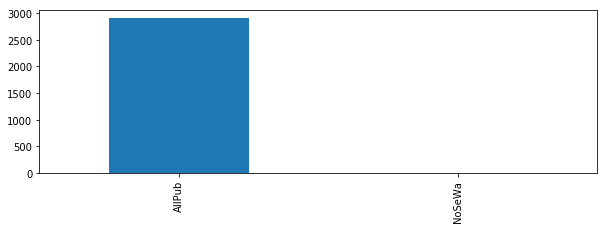

In [19]:
object_columns_df['Utilities'].value_counts().plot(kind='bar',figsize=[10,3])
object_columns_df['Utilities'].value_counts() 


Pave    2907
Grvl      12
Name: Street, dtype: int64

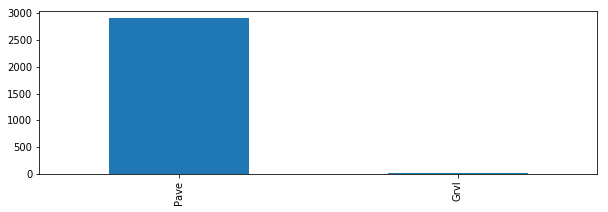

In [20]:
object_columns_df['Street'].value_counts().plot(kind='bar',figsize=[10,3])
object_columns_df['Street'].value_counts() 

Norm      2889
Feedr       13
Artery       5
PosN         4
PosA         4
RRNn         2
RRAe         1
RRAn         1
Name: Condition2, dtype: int64

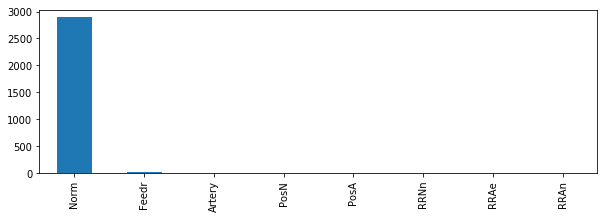

In [21]:
object_columns_df['Condition2'].value_counts().plot(kind='bar',figsize=[10,3])
object_columns_df['Condition2'].value_counts() 


CompShg    2876
Tar&Grv      23
WdShake       9
WdShngl       7
Roll          1
Membran       1
ClyTile       1
Metal         1
Name: RoofMatl, dtype: int64

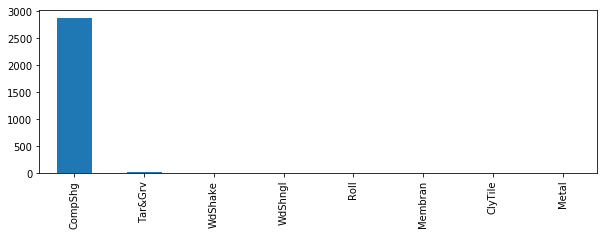

In [22]:
object_columns_df['RoofMatl'].value_counts().plot(kind='bar',figsize=[10,3])
object_columns_df['RoofMatl'].value_counts() 

GasA     2874
GasW       27
Grav        9
Wall        6
OthW        2
Floor       1
Name: Heating, dtype: int64

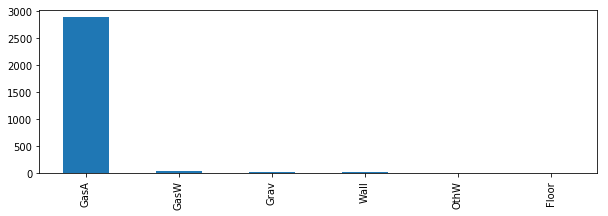

In [23]:
object_columns_df['Heating'].value_counts().plot(kind='bar',figsize=[10,3])
object_columns_df['Heating'].value_counts() #======> Drop feature one Type


In [24]:
object_columns_df = object_columns_df.drop(['Heating','RoofMatl','Condition2','Street','Utilities'],axis=1)


* <font color='gris'> **Now we will create some new features**  <font>

In [25]:
numerical_columns_df['Age_House']= (numerical_columns_df['YrSold']-numerical_columns_df['YearBuilt'])
numerical_columns_df['Age_House'].describe()


count    2919.000000
mean       36.479959
std        30.336182
min        -1.000000
25%         7.000000
50%        35.000000
75%        54.500000
max       136.000000
Name: Age_House, dtype: float64

In [26]:
Negatif = numerical_columns_df[numerical_columns_df['Age_House'] < 0]
Negatif


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,train,Age_House
1089,2550,20,128.0,39290,10,5,2008,2009,1224.0,4010.0,...,0,0,0,0,17000,10,2007,0.0,0,-1



* <font color='gris'> Like we see here tha the minimun is -1 ??? <font>
* <font color='gris'>It is strange to find that the house was sold in 2007 before the YearRemodAdd 2009.

    So we decide to change the year of sold to 2009 <font>

In [27]:
numerical_columns_df.loc[numerical_columns_df['YrSold'] < numerical_columns_df['YearBuilt'],'YrSold' ] = 2009
numerical_columns_df['Age_House']= (numerical_columns_df['YrSold']-numerical_columns_df['YearBuilt'])
numerical_columns_df['Age_House'].describe()


count    2919.000000
mean       36.480644
std        30.335358
min         0.000000
25%         7.000000
50%        35.000000
75%        54.500000
max       136.000000
Name: Age_House, dtype: float64

 <font color='gris'> 
* TotalBsmtBath : Sum of :
BsmtFullBath and  1/2 BsmtHalfBath

* TotalBath : Sum of :
FullBath and 1/2 HalfBath

* TotalSA : Sum of : 
1stFlrSF and 2ndFlrSF and basement area
</font>





In [28]:
numerical_columns_df['TotalBsmtBath'] = numerical_columns_df['BsmtFullBath'] + numerical_columns_df['BsmtFullBath']*0.5
numerical_columns_df['TotalBath'] = numerical_columns_df['FullBath'] + numerical_columns_df['HalfBath']*0.5 
numerical_columns_df['TotalSA']=numerical_columns_df['TotalBsmtSF'] + numerical_columns_df['1stFlrSF'] + numerical_columns_df['2ndFlrSF']


In [29]:
numerical_columns_df.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,PoolArea,MiscVal,MoSold,YrSold,SalePrice,train,Age_House,TotalBsmtBath,TotalBath,TotalSA
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,0,0,2,2008,208500.0,1,5,1.5,2.5,2566.0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,0,0,5,2007,181500.0,1,31,0.0,2.0,2524.0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,0,0,9,2008,223500.0,1,7,1.5,2.5,2706.0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,...,0,0,2,2006,140000.0,1,91,1.5,1.0,2473.0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,...,0,0,12,2008,250000.0,1,8,1.5,2.5,3343.0



* <font color='gris'>  Now the next step is to encode categorical features  <font>



* <font color='gris'>  **Ordinal categories features** - Mapping from 0 to N  <font>

In [30]:
bin_map  = {'TA':2,'Gd':3, 'Fa':1,'Ex':4,'Po':1,'None':0,'Y':1,'N':0,'Reg':3,'IR1':2,'IR2':1,'IR3':0,"None" : 0,
            "No" : 2, "Mn" : 2, "Av": 3,"Gd" : 4,"Unf" : 1, "LwQ": 2, "Rec" : 3,"BLQ" : 4, "ALQ" : 5, "GLQ" : 6
            }
object_columns_df['ExterQual'] = object_columns_df['ExterQual'].map(bin_map)
object_columns_df['ExterCond'] = object_columns_df['ExterCond'].map(bin_map)
object_columns_df['BsmtCond'] = object_columns_df['BsmtCond'].map(bin_map)
object_columns_df['BsmtQual'] = object_columns_df['BsmtQual'].map(bin_map)
object_columns_df['HeatingQC'] = object_columns_df['HeatingQC'].map(bin_map)
object_columns_df['KitchenQual'] = object_columns_df['KitchenQual'].map(bin_map)
object_columns_df['FireplaceQu'] = object_columns_df['FireplaceQu'].map(bin_map)
object_columns_df['GarageQual'] = object_columns_df['GarageQual'].map(bin_map)
object_columns_df['GarageCond'] = object_columns_df['GarageCond'].map(bin_map)
object_columns_df['CentralAir'] = object_columns_df['CentralAir'].map(bin_map)
object_columns_df['LotShape'] = object_columns_df['LotShape'].map(bin_map)
object_columns_df['BsmtExposure'] = object_columns_df['BsmtExposure'].map(bin_map)
object_columns_df['BsmtFinType1'] = object_columns_df['BsmtFinType1'].map(bin_map)
object_columns_df['BsmtFinType2'] = object_columns_df['BsmtFinType2'].map(bin_map)

PavedDrive =   {"N" : 0, "P" : 1, "Y" : 2}
object_columns_df['PavedDrive'] = object_columns_df['PavedDrive'].map(PavedDrive)




* <font color='gris'>  Will we use One hot encoder to encode the rest of categorical features  <font>

In [31]:
#Select categorical features
rest_object_columns = object_columns_df.select_dtypes(include=['object'])
#Using One hot encoder
object_columns_df = pd.get_dummies(object_columns_df, columns=rest_object_columns.columns) 


In [32]:
object_columns_df.head()

,LotShape,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,3,4,2,4,2,2,6,1,4,1,...,0,0,0,1,0,0,0,0,1,0
1,3,2,2,4,2,4,5,1,4,1,...,0,0,0,1,0,0,0,0,1,0
2,2,4,2,4,2,2,6,1,4,1,...,0,0,0,1,0,0,0,0,1,0
3,2,2,2,2,4,2,5,1,4,1,...,0,0,0,1,1,0,0,0,0,0
4,2,4,2,4,2,3,6,1,4,1,...,0,0,0,1,0,0,0,0,1,0



* <font color='gris'>  Concat Categorical (after encoding) and numerical features  <font>


In [33]:
df_final = pd.concat([object_columns_df, numerical_columns_df], axis=1,sort=False)
df_final.head()

,LotShape,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,CentralAir,...,PoolArea,MiscVal,MoSold,YrSold,SalePrice,train,Age_House,TotalBsmtBath,TotalBath,TotalSA
0,3,4,2,4,2,2,6,1,4,1,...,0,0,2,2008,208500.0,1,5,1.5,2.5,2566.0
1,3,2,2,4,2,4,5,1,4,1,...,0,0,5,2007,181500.0,1,31,0.0,2.0,2524.0
2,2,4,2,4,2,2,6,1,4,1,...,0,0,9,2008,223500.0,1,7,1.5,2.5,2706.0
3,2,2,2,2,4,2,5,1,4,1,...,0,0,2,2006,140000.0,1,91,1.5,1.0,2473.0
4,2,4,2,4,2,3,6,1,4,1,...,0,0,12,2008,250000.0,1,8,1.5,2.5,3343.0


In [34]:
df_final = df_final.drop(['Id',],axis=1)

df_train = df_final[df_final['train'] == 1]
df_train = df_train.drop(['train',],axis=1)


df_test = df_final[df_final['train'] == 0]
df_test = df_test.drop(['SalePrice'],axis=1)
df_test = df_test.drop(['train',],axis=1)



* <font color='gris'>  Separate Train and Targets  <font>

In [35]:
target= df_train['SalePrice']
df_train = df_train.drop(['SalePrice'],axis=1)

#  <font color='blue'> Modeling  </font>

In [36]:
x_train,x_test,y_train,y_test = train_test_split(df_train,target,test_size=0.33,random_state=0)

In [37]:

xgb =XGBRegressor( booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=4, min_child_weight=1.5, n_estimators=2400,
             n_jobs=1, nthread=None, objective='reg:linear',
             reg_alpha=0.6, reg_lambda=0.6, scale_pos_weight=1, 
             silent=None, subsample=0.8, verbosity=1)


lgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=12000, 
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.4, 
                                       )


In [38]:
#Fitting
xgb.fit(x_train, y_train)
lgbm.fit(x_train, y_train,eval_metric='rmse')


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[23:40:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


LGBMRegressor(bagging_fraction=0.75, bagging_freq=5, bagging_seed=7,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.4, importance_type='split', learning_rate=0.01,
              max_bin=200, max_depth=-1, min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=12000,
              n_jobs=-1, num_leaves=4, objective='regression',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [39]:
predict1 = xgb.predict(x_test)
predict = lgbm.predict(x_test)


In [40]:
print('Root Mean Square Error test = ' + str(math.sqrt(metrics.mean_squared_error(y_test, predict1))))
print('Root Mean Square Error test = ' + str(math.sqrt(metrics.mean_squared_error(y_test, predict))))


Root Mean Square Error test = 26089.30803984919
Root Mean Square Error test = 26726.198278903514



* <font color='gris'> Fitting With all the dataset <font>

In [41]:
xgb.fit(df_train, target)
lgbm.fit(df_train, target,eval_metric='rmse')


[23:41:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


LGBMRegressor(bagging_fraction=0.75, bagging_freq=5, bagging_seed=7,
              boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.4, importance_type='split', learning_rate=0.01,
              max_bin=200, max_depth=-1, min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=12000,
              n_jobs=-1, num_leaves=4, objective='regression',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [42]:
predict4 = lgbm.predict(df_test)
predict3 = xgb.predict(df_test)
predict_y = ( predict3*0.45 + predict4 * 0.55)


In [43]:
submission = pd.DataFrame({
        "Id": test["Id"],
        "SalePrice": predict_y
    })
submission.to_csv('submission.csv', index=False)
